# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.pyplot import figure

In [2]:
data = pd.read_parquet('/content/data_parquet.parquet')

In [3]:
data

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


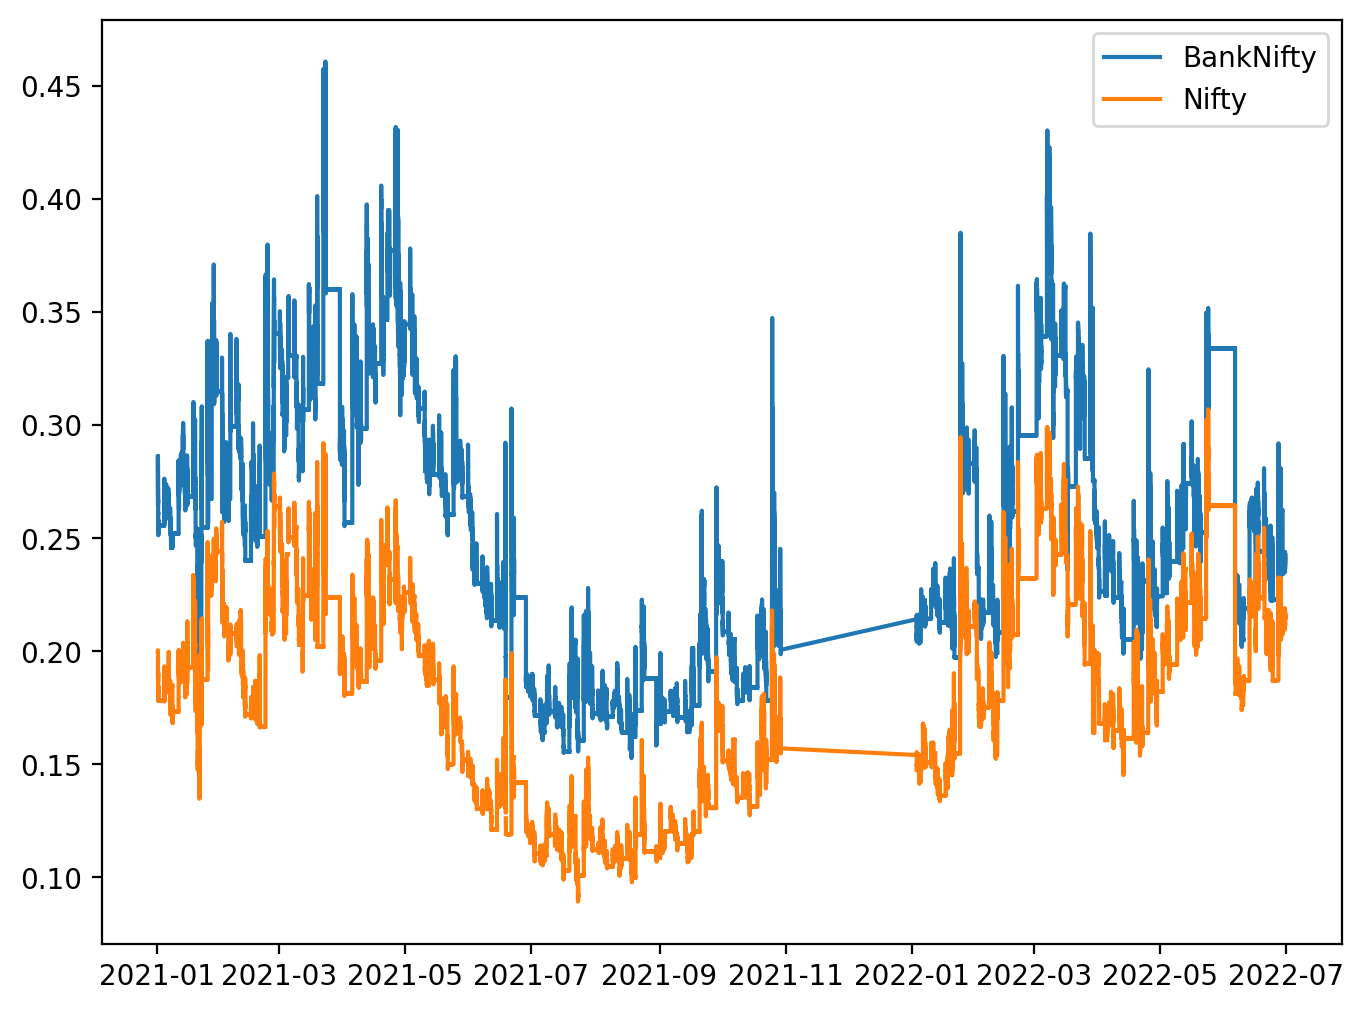

In [4]:
figure(figsize=(8, 6), dpi=200)
plt.plot(data['banknifty'],label="BankNifty")
plt.plot(data['nifty'],label="Nifty")
plt.legend()


<Axes: >

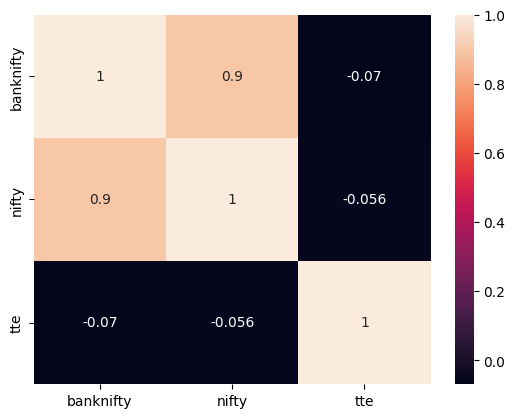

In [5]:
sn.heatmap(data.corr(), annot = True)

Thus we observe High Cor-relation=0.9 ( >0.8) between BankNifty & Nifty from the heatmap.

In [6]:
# Forward fill missing values
data = data.ffill()

# Z-score based trading system.

<ipython-input-7-4749e9c75543>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Spread'] = data['banknifty'] - data['nifty']
<ipython-input-7-4749e9c75543>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TimeToExpiry_0.7'] = data['tte'] ** 0.7
<ipython-input-7-4749e9c75543>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

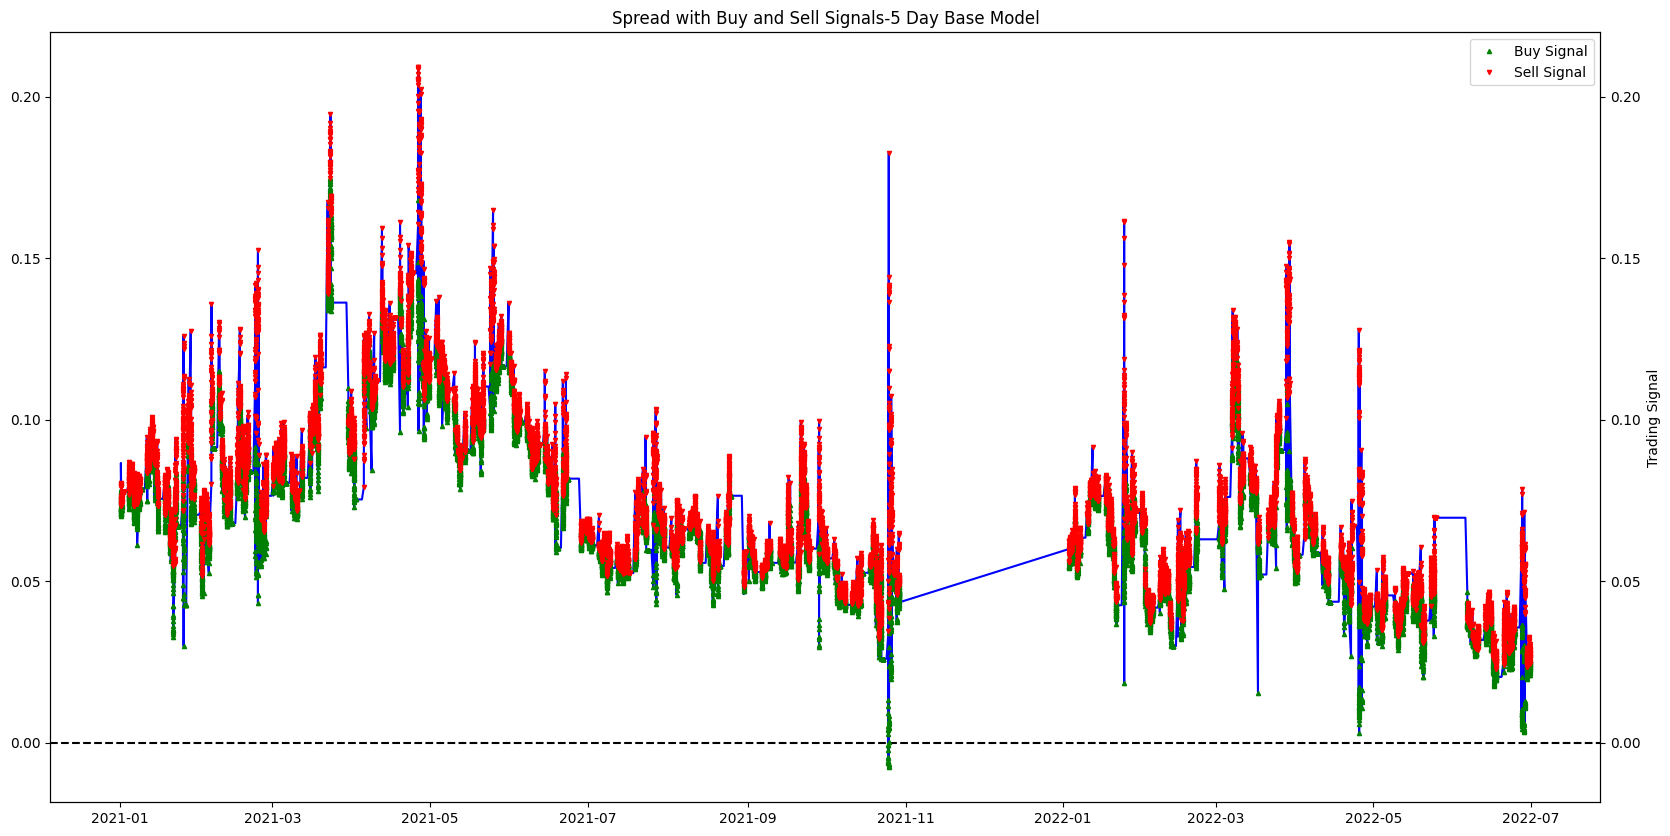

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Filter data for trading hours
data = data[(data.index.time >= pd.to_datetime('09:15').time()) & (data.index.time <= pd.to_datetime('15:30').time())]


# Calculate the spread
data['Spread'] = data['banknifty'] - data['nifty']

# Calculate time to expiry raised to the power of 0.7
data['TimeToExpiry_0.7'] = data['tte'] ** 0.7

# Calculate z-score
data['Spread_Zscore'] = (data['Spread'] - data['Spread'].rolling(window=30).mean()) / data['Spread'].rolling(window=30).std() # 30 min trading frequency

# Define trading signals based on z-score
data['Signal'] = np.where(data['Spread_Zscore'] > 1, -1, np.where(data['Spread_Zscore'] < -1, 1, 0))

# Calculate P/L based on signals
data['PnL'] = data['Signal'].shift(1) * data['Spread'] * data['TimeToExpiry_0.7']

# Cumulative P/L
data['Cumulative_PnL'] = (1 + data['PnL'] / 100).cumprod()


# Plotting
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot Spread
ax1.plot(data.index, data['Spread'], label='Spread', color='blue')
ax1.axhline(0, linestyle='--', color='black', label='Spread Mean')

# Create a second y-axis for signals
ax2 = ax1.twinx()

# Plot Buy signals (Green Upward Triangle)
ax2.plot(data[data['Signal'] == 1].index, data['Spread'][data['Signal'] == 1], '^', markersize=3, color='g', label='Buy Signal')

# Plot Sell signals (Red Downward Triangle)
ax2.plot(data[data['Signal'] == -1].index, data['Spread'][data['Signal'] == -1], 'v', markersize=3, color='r', label='Sell Signal')

ax2.set_ylabel('Trading Signal', color='black')
ax2.tick_params('y', colors='black')

plt.title('Spread with Buy and Sell Signals-5 Day Base Model')
plt.legend()
plt.show()

In [53]:
#Base-Model Results:
cumulative_pnl_base_model = data['Cumulative_PnL']

absolute_PnL_base_model = cumulative_pnl_base_model[-1]-1


print("Base Model - Cumulative PnL: {:.4}".format(cumulative_pnl_base_model[-1]))
print("Base Model - Absolute PnL: {:.4}".format(absolute_PnL_base_model))
print("Sharpe Ratio : {:.2%}".format(cumulative_pnl_base_model.pct_change().mean() / cumulative_pnl_base_model.pct_change().std()))

Base Model - Cumulative PnL: 11.84
Base Model - Absolute PnL: 10.84
Sharpe Ratio : 0.61%


# Simple RFC (Random Forest Classifier)

In [62]:

'''
After exploring the features and considering other technical indicators such as lagged values of the spread,moving averages,
and volatility measures. The lagged values were best indicative of future spread values and thus I finally used them with simple
random forest classifier ( a bagging algorithm) to make decision for time series analysis.
'''

# Model
data['Spread_Lag1'] = data['Spread'].shift(1)
data['Spread_Lag2'] = data['Spread'].shift(2)



In [30]:

data['Label'] = np.where(data['Spread_Zscore'] > 1, -1, np.where(data['Spread_Zscore'] < -1, 1, 0))
data.dropna()

,banknifty,nifty,tte,Spread,TimeToExpiry_0.7,Spread_Zscore,Signal,PnL,Cumulative_PnL,Predicted_Spread,Residual,Model2_Position,Model2_PnL,Predicted_Spread_m3,Residual_m3,Model2_Position_m3,Model2_PnL_m3,Spread_Lag1,Spread_Lag2,Label
time,,,,,,,,,,,,,,,,,,,,
2021-01-01 09:44:00,0.272056,0.193597,27,0.078458,10.045109,-1.439055,1,0.000000,1.000000,0.073621,0.004837,-1,0.000000,-0.078459,0.156917,-1,0.000000,0.078512,0.077308,1
2021-01-01 09:45:00,0.271123,0.193464,27,0.077659,10.045109,-1.590606,1,0.780088,1.007801,0.073604,0.004055,-1,-0.780088,-0.077659,0.155317,-1,-0.780088,0.078458,0.078512,1
2021-01-01 09:46:00,0.271558,0.193661,27,0.077897,10.045109,-1.398375,1,0.782484,1.015687,0.073630,0.004267,-1,-0.782484,-0.077897,0.155794,-1,-0.782484,0.077659,0.078458,1
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,10.045109,-1.333686,1,0.781319,1.023623,0.073636,0.004145,-1,-0.781319,-0.077781,0.155562,-1,-0.781319,0.077897,0.077659,1
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,10.045109,-1.333164,1,0.778632,1.031593,0.073626,0.003887,-1,-0.778632,-0.077514,0.155027,-1,-0.778632,0.077781,0.077897,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,10.304113,-0.229389,0,0.000000,11.807038,0.076414,-0.050471,1,0.267320,-0.025943,0.051886,-1,-0.267320,0.025162,0.025047,0
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,10.304113,-1.598299,1,0.000000,11.807038,0.076652,-0.052335,1,0.250560,-0.024317,0.048633,-1,-0.250560,0.025943,0.025162,1
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,10.304113,-0.649965,0,0.260910,11.837843,0.076683,-0.051362,1,0.260910,-0.025321,0.050642,-1,-0.260910,0.024317,0.025943,0


In [31]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Select features and labels
features = ['Spread_Lag1', 'Spread_Lag2']  # Add more features as needed
X_train, y_train = train_data[features].fillna(0), train_data['Label'].fillna(0)
X_test, y_test = test_data[features].fillna(0), test_data['Label'].fillna(0)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Evaluate model performance
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)
print(f'Training Accuracy: {accuracy_train:.2f}')
print(f'Test Accuracy: {accuracy_test:.2f}')


Training Accuracy: 1.00
Test Accuracy: 0.50


In [35]:
# Predict labels for the entire dataset
data['ML_Signal'] = model.predict(data[features].fillna(0) )

# Generate trading signals based on predicted labels
data['ML_Trading_Signal'] = np.where(data['ML_Signal'] == -1, 'Sell', np.where(data['ML_Signal'] == 1, 'Buy', 'Hold'))


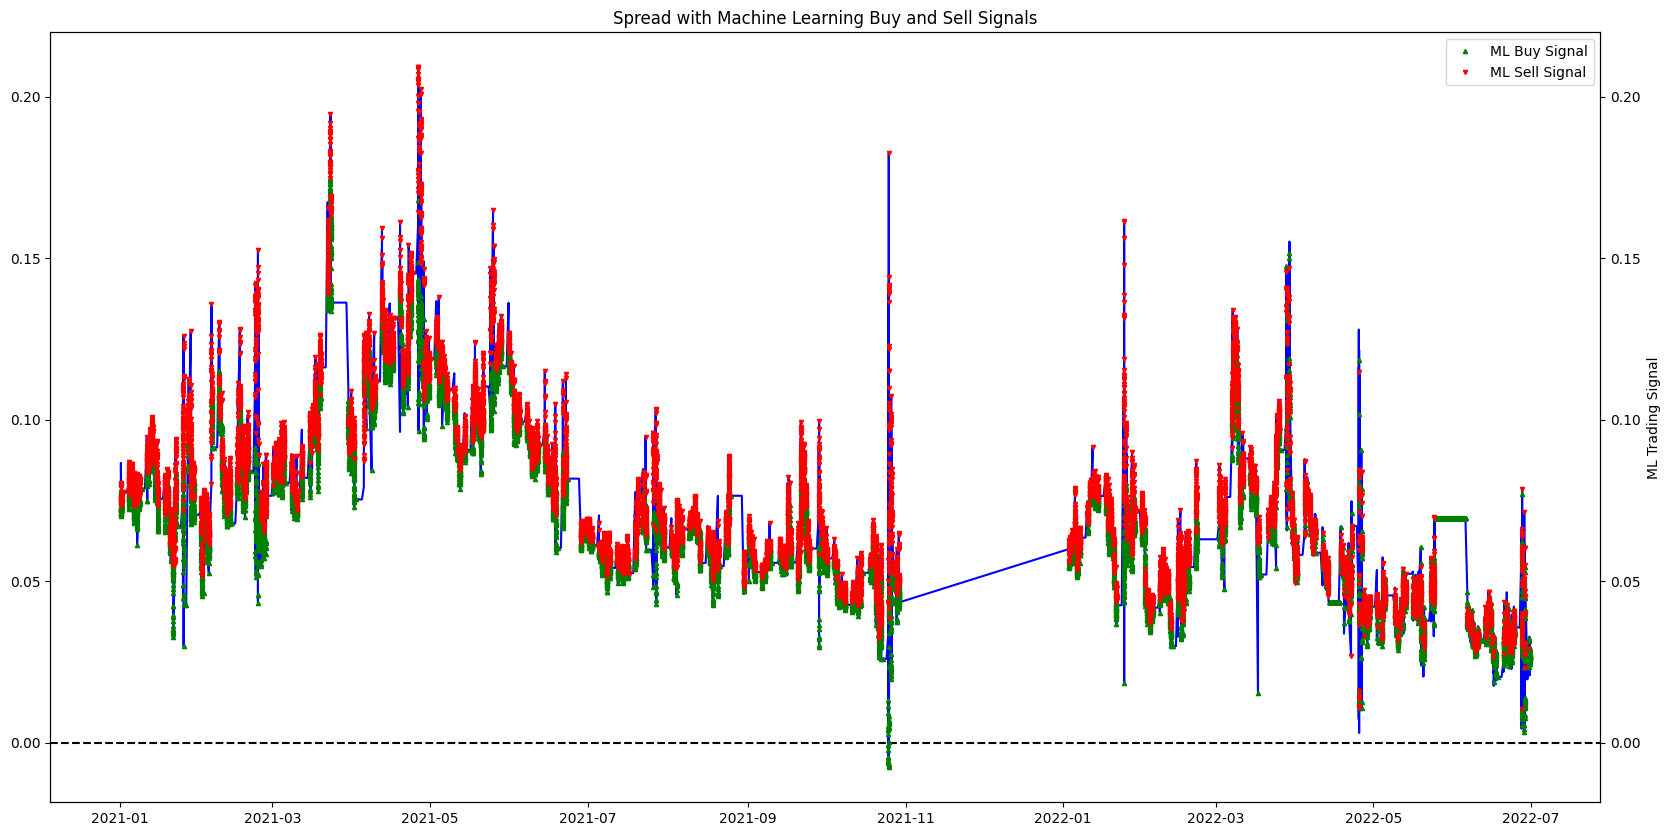

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already processed your data and trained the model as per the previous code snippets

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot Spread
ax1.plot(data.index, data['Spread'], label='Spread', color='blue')
ax1.axhline(0, linestyle='--', color='black', label='Spread Mean')

# Create a second y-axis for machine learning signals
ax2 = ax1.twinx()

# Plot Buy signals (Green Upward Triangle)
ax2.plot(data[data['ML_Signal'] == 1].index, data['Spread'][data['ML_Signal'] == 1], '^', markersize=3, color='g', label='ML Buy Signal')

# Plot Sell signals (Red Downward Triangle)
ax2.plot(data[data['ML_Signal'] == -1].index, data['Spread'][data['ML_Signal'] == -1], 'v', markersize=3, color='r', label='ML Sell Signal')

ax2.set_ylabel('ML Trading Signal', color='black')
ax2.tick_params('y', colors='black')

plt.title('Spread with Machine Learning Buy and Sell Signals')
plt.legend()
plt.show()


In [37]:
data

,banknifty,nifty,tte,Spread,TimeToExpiry_0.7,Spread_Zscore,Signal,PnL,Cumulative_PnL,Predicted_Spread,...,Model2_PnL,Predicted_Spread_m3,Residual_m3,Model2_Position_m3,Model2_PnL_m3,Spread_Lag1,Spread_Lag2,Label,ML_Signal,ML_Trading_Signal
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,10.045109,NaN,0,NaN,NaN,0.074431,...,NaN,-0.086329,0.172658,0,NaN,NaN,NaN,0,0,Hold
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,10.045109,NaN,0,0.00000,1.000000,0.074523,...,0.000000,-0.084949,0.169897,0,0.000000,0.086329,NaN,0,0,Hold
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,10.045109,NaN,0,0.00000,1.000000,0.074467,...,0.000000,-0.084229,0.168458,0,0.000000,0.084948,0.086329,0,0,Hold
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,10.045109,NaN,0,0.00000,1.000000,0.074448,...,0.000000,-0.086244,0.172487,0,0.000000,0.084229,0.084948,0,0,Hold
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,10.045109,NaN,0,0.00000,1.000000,0.074328,...,0.000000,-0.086588,0.173176,0,0.000000,0.086244,0.084229,0,0,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,10.304113,-0.229389,0,0.00000,11.807038,0.076414,...,0.267320,-0.025943,0.051886,-1,-0.267320,0.025162,0.025047,0,0,Hold
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,10.304113,-1.598299,1,0.00000,11.807038,0.076652,...,0.250560,-0.024317,0.048633,-1,-0.250560,0.025943,0.025162,1,0,Hold
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,10.304113,-0.649965,0,0.26091,11.837843,0.076683,...,0.260910,-0.025321,0.050642,-1,-0.260910,0.024317,0.025943,0,0,Hold


In [39]:
data['ML PnL'] = data['ML_Signal'].shift(1) * data['Spread'] * data['TimeToExpiry_0.7']

# Cumulative P/L
data['ML Cumulative_PnL'] = (1 + data['ML PnL'] / 100).cumprod()

In [66]:
print("RFC-ML Model - Cumulative PnL: {:.2}".format(data['ML Cumulative_PnL'][-1]))
print("RFC-ML Model - Absolute PnL: {:.2}".format(data['ML Cumulative_PnL'][-1]-1))

print("RFC-ML Sharpe Ratio: {:.2%}".format(data['ML Cumulative_PnL'].pct_change().mean() / data['ML Cumulative_PnL'].pct_change().std()))


RFC-ML Model - Cumulative PnL: 8.7e+09
RFC-ML Model - Absolute PnL: 8.7e+09
RFC-ML Sharpe Ratio: 4.45%


## Findings


### Over the past couple of weeks I explored featuring modelling spread, moving averages and volatility measures.

### After exploring the features and considering other technical indicators such as lagged values of the spread, moving averages and volatility measures. The lagged values were best indicative of future spread values and thus I finally used them with simple  random forest classifier (a bagging algorithm) to make decision for time series analysis.

### We could see a significant improvement both in PnL and sharpe ratio.

### Thus we have trained a simple random-forest classifier model which is better in terms of PnL and sharpe ratio as compared to Z-score model.
